# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

state = np.random.RandomState(12345)

In [25]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head(20))
display(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [26]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [27]:
data.loc[data['VehicleType'].isna() == True].head(50)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08


Пропуски имеются в колонках VehicleType, Gearbox, Model, FuelType, Repaired, в достаточно большом количестве, что бы обратить на них внимание. Все эти пропуски относятся к полностью случайным, поскольку не зависят от данных в других столбцах. 
Попытаемся найти какую-нибудь закономерность в появленнии пропусков в столбце с типом машины: из выведенных 50 строк видно, что 
большинство машин из категории small, но также попадаются седаны, кроссоверы и даже транcпортер, поэтому пропуски придется заполнять новой категорией "unknown". Так же поступим с пропусками в столбцах Gearbox, Model, FuelType. Пропуски в столбце Repaired заменим на значение "no", предполагая, что машина не ремотировалась.
Столбцы DateCreated, DateCrawled идентичны, хранят значения о дате и времени создания объявления, качество модели они не улучшат,  ведь на цену авто влияет скорее год выпуска, поэтому удалим их.
Столбцы NumberOfPictures, PostalCode, LastSeen, RegistrationMonth также не повлияют на улучшение качества модели.


In [28]:
col_unknown = ['VehicleType', 'Gearbox', 'Model', 'FuelType']
for col in col_unknown:
    data[col] = data[col].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('no')
data = data.drop(['DateCreated', 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [29]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Оценим распределение данных. В столбце price и kilometer ничего не смущает, выбросов нет, распределение- нормальное.

Text(0, 0.5, 'Cars')

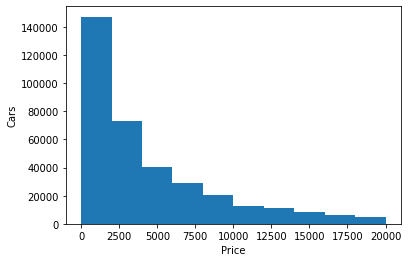

In [30]:
plt.hist(data['Price'])
plt.xlabel("Price")
plt.ylabel("Cars")

In [31]:
data = data.loc[data['Price'] > 1000]
data.describe()


,Price,RegistrationYear,Power,Kilometer
count,266394.000000,266394.000000,266394.000000,266394.000000
mean,5699.998416,2004.785581,122.038732,125681.528112
std,4520.785920,56.596921,193.708836,38337.809603
min,1001.000000,1000.000000,0.000000,5000.000000
25%,2200.000000,2001.000000,77.000000,100000.000000
50%,4000.000000,2005.000000,116.000000,150000.000000
75%,7950.000000,2008.000000,150.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Text(0, 0.5, 'Cars')

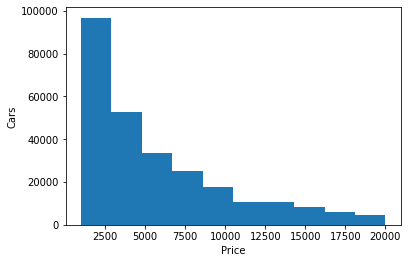

In [32]:
plt.hist(data['Price'])
plt.xlabel("Price")
plt.ylabel("Cars")

В столбце RegistrationYear очевидно есть выбросы: минимальное значение года выпуска 1000, максимальное: 9999.
В столбце Power также есть выбросы: минимальное значение лошадиных сил: 0, максимальное: 20к. 

Text(0, 0.5, 'Cars')

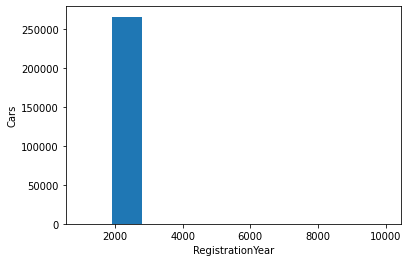

In [33]:
plt.hist(data['RegistrationYear'])
plt.xlabel("RegistrationYear")
plt.ylabel("Cars")

Удалим эти выбросы и построим гистограмму вновь:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247468 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             247468 non-null  int64 
 1   VehicleType       247468 non-null  object
 2   RegistrationYear  247468 non-null  int64 
 3   Gearbox           247468 non-null  object
 4   Power             247468 non-null  int64 
 5   Model             247468 non-null  object
 6   Kilometer         247468 non-null  int64 
 7   FuelType          247468 non-null  object
 8   Brand             247468 non-null  object
 9   Repaired          247468 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


None

Text(0, 0.5, 'Cars')

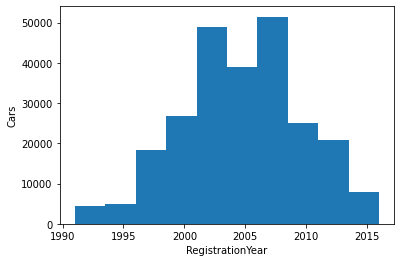

In [34]:
data = data.loc[(data['RegistrationYear'] > 1990) & (data['RegistrationYear'] < 2017)]
display(data.info())
plt.hist(data['RegistrationYear'])
plt.xlabel("RegistrationYear")
plt.ylabel("Cars")

Теперь отмечается распределение, приближенное к нормальному.

Text(0, 0.5, 'Cars')

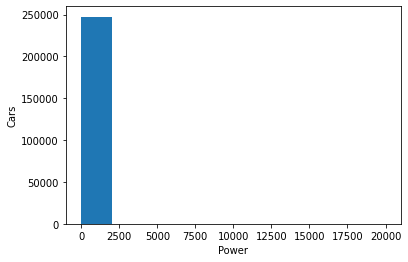

In [35]:
plt.hist(data['Power'])
plt.xlabel("Power")
plt.ylabel("Cars")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230599 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             230599 non-null  int64 
 1   VehicleType       230599 non-null  object
 2   RegistrationYear  230599 non-null  int64 
 3   Gearbox           230599 non-null  object
 4   Power             230599 non-null  int64 
 5   Model             230599 non-null  object
 6   Kilometer         230599 non-null  int64 
 7   FuelType          230599 non-null  object
 8   Brand             230599 non-null  object
 9   Repaired          230599 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.4+ MB


None

Text(0, 0.5, 'Cars')

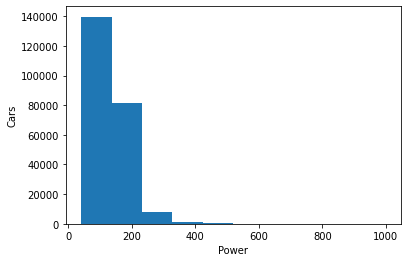

In [36]:
data = data.loc[(data['Power'] > 40) & (data['Power'] < 1000)]
display(data.info())
plt.hist(data['Power'])
plt.xlabel("Power")
plt.ylabel("Cars")

Text(0, 0.5, 'Cars')

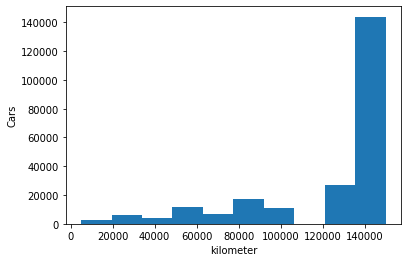

In [37]:
plt.hist(data['Kilometer'])
plt.xlabel("kilometer")
plt.ylabel("Cars")

Разделим признаки на целевой и обучающие: 

In [39]:
features = data.drop(['Price'], axis=1)
target = data['Price']
display(features.shape)
display(target.shape)

(230599, 9)

(230599,)

Разделим данные на тренировочную и тестовую выборки в соотношении 3 к 1:

In [40]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=state)
display(x_train.shape)
display(x_test.shape)
display(y_train.shape)
display(y_test.shape)

(172949, 9)

(57650, 9)

(172949,)

(57650,)

Так как мы планируем работать с алгоримтами, в основе которых лежат деревья, закодируем наши категориальные признаки с помощью LabelEncoder:

In [41]:
pd.options.mode.chained_assignment = None

to_encode = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
le = OrdinalEncoder(handle_unknown='ignore')
x_train_oe = x_train.copy()
x_test_oe = x_test.copy()

#le.fit_transform(features[col])
x_train_oe[to_encode] = le.fit_transform(x_train[to_encode])
x_test_oe[to_encode] = le.transform(x_test[to_encode])

display(x_train_oe.head(10))
display(x_test_oe.head(10))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
312855,7.0,2000,1.0,150,116.0,125000,6.0,38.0,0.0
210239,8.0,2001,1.0,107,136.0,150000,6.0,27.0,0.0
139751,6.0,2006,0.0,258,238.0,150000,2.0,2.0,0.0
219401,4.0,1999,0.0,136,111.0,60000,6.0,22.0,0.0
206133,4.0,2010,1.0,59,101.0,150000,6.0,31.0,0.0
83867,4.0,2010,0.0,170,6.0,60000,6.0,2.0,0.0
346892,2.0,2005,1.0,280,166.0,150000,6.0,23.0,0.0
284989,4.0,2002,1.0,192,11.0,150000,6.0,2.0,0.0
302923,5.0,2006,1.0,87,242.0,150000,6.0,36.0,0.0
106807,5.0,2011,1.0,68,46.0,90000,6.0,36.0,0.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
15491,4.0,2010,1.0,116,6.0,150000,2.0,2.0,0.0
169988,7.0,2016,1.0,60,224.0,150000,6.0,25.0,1.0
183567,4.0,2005,1.0,105,116.0,150000,2.0,38.0,0.0
128280,5.0,2002,1.0,75,83.0,150000,6.0,24.0,0.0
114237,6.0,2003,1.0,114,239.0,150000,2.0,23.0,0.0
335822,4.0,1998,1.0,75,116.0,150000,6.0,38.0,0.0
307324,6.0,2006,0.0,150,196.0,150000,2.0,12.0,0.0
130195,6.0,2012,1.0,163,166.0,70000,2.0,3.0,0.0
330510,4.0,2001,1.0,120,136.0,150000,6.0,27.0,0.0
82700,4.0,1999,1.0,120,3.0,125000,6.0,0.0,0.0


## Обучение моделей

По условиям постааленной задачи от нас требуется обучить модель LightGBM, и как минимум одну модель, в алгоритме которой не применяется бустинг - я выбрал случаный лес.
Обучим модель LightGBM и сразу проверим результат на тестовой выборке. Далее проконтролируем качетсво модели с помощью кросс-валидации так как мы не создавали валидационную выборку. 

Подберем гиперпараметры для модели LightGBM с помощью поиска по сетке. Т.к. это довольно затяжной процесс, снизим количество гиперпараметров. 

In [19]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=state)

parameters = {
    'task' : ['predict'],
    'boosting': ['gbdt' ],
    'objective': ['root_mean_squared_error'],
    'num_iterations': [  1500, 2000  ],
    'learning_rate':[ 0.05 ],
    'num_leaves':[ 10, 15 ],
    'max_depth' :[ 10, 15 ],
   
}

gsearch_lgb = GridSearchCV(lgb_model, param_grid = parameters, scoring='neg_root_mean_squared_error', n_jobs=6, verbose=10, cv = 5)
gsearch_lgb.fit(x_train_oe,y_train)
 
print('best params')
print (gsearch_lgb.best_params_)
score = gsearch_lgb.best_score_
print('RMSE:', -score)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
best params
{'boosting': 'gbdt', 'learning_rate': 0.05, 'max_depth': 15, 'num_iterations': 2000, 'num_leaves': 15, 'objective': 'root_mean_squared_error', 'task': 'predict'}
RMSE: 1567.8900015745353
CPU times: user 45.6 s, sys: 367 ms, total: 45.9 s
Wall time: 11min 21s


best params
{'boosting': 'gbdt', 'learning_rate': 0.05, 'max_depth': 15, 'num_iterations': 1500, 'num_leaves': 15, 'objective': 'root_mean_squared_error', 'task': 'predict'}
CPU times: user 21min 24s, sys: 8.02 s, total: 21min 32s
Wall time: 28min 24s

In [20]:
results = pd.DataFrame(gsearch_lgb.cv_results_)
display(results)
display(results[results['rank_test_score']==1])
fit_time = results[results['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time = results[results['rank_test_score']==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time: {predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting,param_learning_rate,param_max_depth,param_num_iterations,param_num_leaves,param_objective,param_task,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,34.676946,15.041034,15.139098,5.838036,gbdt,0.05,10,1500,10,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1602.657205,-1635.279847,-1624.545716,-1626.946100,-1598.209578,-1617.527689,14.473555,7
1,62.000388,5.732523,26.145072,1.098423,gbdt,0.05,10,1500,15,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1562.923858,-1603.492063,-1589.318212,-1594.768821,-1569.173701,-1583.935331,15.415534,4
2,80.362702,9.157317,32.477732,3.086459,gbdt,0.05,10,2000,10,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1581.468307,-1617.837864,-1607.548816,-1607.269613,-1581.629801,-1599.150880,14.868114,5
3,86.685722,2.866936,33.159373,3.176140,gbdt,0.05,10,2000,15,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1546.476979,-1588.268252,-1573.879150,-1578.299797,-1554.133684,-1568.211572,15.535402,2
4,61.022343,5.519270,22.938407,2.495382,gbdt,0.05,15,1500,10,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1602.657205,-1635.279847,-1624.545716,-1626.946100,-1598.209578,-1617.527689,14.473555,7
5,56.020308,4.133146,23.317012,2.028133,gbdt,0.05,15,1500,15,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1564.051609,-1602.803590,-1592.236283,-1592.701352,-1567.341522,-1583.826871,15.312859,3
6,74.239239,4.241683,28.544974,1.192109,gbdt,0.05,15,2000,10,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1581.468307,-1617.837864,-1607.548816,-1607.269613,-1581.629801,-1599.150880,14.868114,5
7,66.167873,9.143600,17.211477,8.789468,gbdt,0.05,15,2000,15,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1545.187982,-1587.556297,-1578.192915,-1576.298724,-1552.214089,-1567.890002,16.277197,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting,param_learning_rate,param_max_depth,param_num_iterations,param_num_leaves,param_objective,param_task,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,66.167873,9.1436,17.211477,8.789468,gbdt,0.05,15,2000,15,root_mean_squared_error,predict,"{'boosting': 'gbdt', 'learning_rate': 0.05, 'm...",-1545.187982,-1587.556297,-1578.192915,-1576.298724,-1552.214089,-1567.890002,16.277197,1


Fit time: 66.16787252426147, predict time: 17.211476707458495


Fit time: 68.361079788208, predict time: 17.903288888931275

Обучим модель случайного леса, подбирая гиперпараметры с помощью поиска сеткой.

In [21]:
%%time

forest = RandomForestRegressor(random_state=state)

params = { 
    'n_estimators': [10, 15], 
    'max_depth': [3, 5, 10, 15], 
    'min_samples_leaf': [1, 2, 5], 
}

clf = GridSearchCV(estimator=forest, param_grid=params, scoring='neg_mean_squared_error', cv=5)
clf.fit(x_train_oe, y_train)
best_params = clf.best_params_
score = clf.best_score_
print("RMSE:", np.sqrt(-score))



RMSE: 1636.4455546915478
CPU times: user 3min 15s, sys: 439 ms, total: 3min 15s
Wall time: 3min 15s


In [22]:
forest_results = pd.DataFrame(clf.cv_results_)
display(forest_results)
display(forest_results[forest_results['rank_test_score']==1])
fit_time = forest_results[forest_results['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time = forest_results[forest_results['rank_test_score']==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time: {predict_time}')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.582350,0.017164,0.012053,0.000213,3,1,10,"{'max_depth': 3, 'min_samples_leaf': 1, 'n_est...",-8.029187e+06,-8.163029e+06,-8.152710e+06,-8.398427e+06,-8.255104e+06,-8.199692e+06,122629.304531,19
1,0.901869,0.068514,0.017372,0.000973,3,1,15,"{'max_depth': 3, 'min_samples_leaf': 1, 'n_est...",-8.016350e+06,-8.165780e+06,-8.192953e+06,-8.415133e+06,-8.312404e+06,-8.220524e+06,135468.563444,22
2,0.640107,0.017646,0.013435,0.000294,3,2,10,"{'max_depth': 3, 'min_samples_leaf': 2, 'n_est...",-8.029187e+06,-8.163029e+06,-8.152710e+06,-8.398427e+06,-8.255104e+06,-8.199692e+06,122629.304531,19
3,0.870008,0.015379,0.016677,0.000563,3,2,15,"{'max_depth': 3, 'min_samples_leaf': 2, 'n_est...",-8.016350e+06,-8.165780e+06,-8.192953e+06,-8.415133e+06,-8.312404e+06,-8.220524e+06,135468.563444,22
4,0.565002,0.002100,0.012026,0.000325,3,5,10,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",-8.029187e+06,-8.163029e+06,-8.152710e+06,-8.398427e+06,-8.255104e+06,-8.199692e+06,122629.304531,19
5,0.866257,0.024602,0.016242,0.000394,3,5,15,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est...",-8.016350e+06,-8.165780e+06,-8.192953e+06,-8.415133e+06,-8.312404e+06,-8.220524e+06,135468.563444,22
6,0.917926,0.033620,0.016721,0.000665,5,1,10,"{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",-5.613594e+06,-5.691450e+06,-5.490704e+06,-5.827679e+06,-5.745868e+06,-5.673859e+06,115180.631181,13
7,1.359649,0.024841,0.023382,0.000498,5,1,15,"{'max_depth': 5, 'min_samples_leaf': 1, 'n_est...",-5.580093e+06,-5.693669e+06,-5.534773e+06,-5.839040e+06,-5.780411e+06,-5.685597e+06,115306.888925,16
8,0.869504,0.012387,0.016009,0.000248,5,2,10,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",-5.613594e+06,-5.691450e+06,-5.490704e+06,-5.827679e+06,-5.745868e+06,-5.673859e+06,115180.631181,13
9,1.328282,0.032528,0.022077,0.000372,5,2,15,"{'max_depth': 5, 'min_samples_leaf': 2, 'n_est...",-5.580093e+06,-5.693669e+06,-5.534773e+06,-5.839040e+06,-5.780411e+06,-5.685597e+06,115306.888925,16


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,3.018049,0.036872,0.093514,0.008098,15,2,15,"{'max_depth': 15, 'min_samples_leaf': 2, 'n_es...",-2.577897e+06,-2.698212e+06,-2.731740e+06,-2.739831e+06,-2.642089e+06,-2.677954e+06,60712.125569,1


Fit time: 3.018049144744873, predict time: 0.09351372718811035


## Проверка лучше модели на тестовой выборке

Итак, у нас получились следующие результаты: 
LightGBM: Fit time: 77.1251621723175, predict time: 17.353675603866577RMSE 1567.8900015745353
RandomForestRegressor: Fit time: 3.347990894317627, predict time: 0.09743266105651856, RMSE 1636.445

Так как заказчику важны качество предсказания, скорость предсказания и время обучения, не смотря на лучшие показатели метрики, модель LightGBM сильно проигрывает обучающему лесу по скорости обучения и предсказания, поэтому тестировать будем модель обучающего леса.


In [23]:
%%time
best_forest = RandomForestRegressor(**best_params)
fit_forest = best_forest.fit(x_train_oe, y_train)
pred = fit_forest.predict(x_test_oe)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print(" RMSE: %f" % (rmse))


 RMSE: 1612.919102
CPU times: user 3.93 s, sys: 4.5 ms, total: 3.93 s
Wall time: 3.94 s
[CV 3/5; 1/8] START boosting=gbdt, learning_rate=0.05, max_depth=10, num_iterations=1500, num_leaves=10, objective=root_mean_squared_error, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 3/5; 1/8] END boosting=gbdt, learning_rate=0.05, max_depth=10, num_iterations=1500, num_leaves=10, objective=root_mean_squared_error, task=predict; total time=  29.7s
[CV 2/5; 2/8] START boosting=gbdt, learning_rate=0.05, max_depth=10, num_iterations=1500, num_leaves=15, objective=root_mean_squared_error, task=predict
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV 2/5; 2/8] END boosting=gbdt, learning_rate=0.05, max_depth=10, num_iterations=1500, num_leaves=15, objective=root_mean_squared_error, task=predict; total time= 1.4min
[CV 2/5; 3/8] START boosting=gbdt, learning_rate

## Вывод

 Результаты на тренировочных данных:
 
LightGBM: Fit time: 77.1251621723175, predict time: 17.353675603866577RMSE, RMSE 1567.89

RandomForestRegressor: Fit time: 3.347990894317627, predict time: 0.09743266105651856, RMSE 1636.44

RMSE RandomForestRegressor на тестовой выборке: 1612.9
